# Основной блокнот

Здесь просиходит работа с финальной моделью: множественные расчеты с различными random state, наборами гиперпараметров и количеством данных в обучающей выборке. Весь блокнот - один большой эксперимент, я просто решил попробовать такой подход и посмотреть к чему он может привести. В работе используются файлы .pickle для сохранения результатов. В словаре models хранятся результаты предсказаний, а не модели))

- **Используемая модель**: CatBoostClassifier.
- **Набор признаков**: из блокнота `1_EDA`, без учета результатов, полученных в блокноте `2_Feature importance`.
- **Гиперпараметры**: два набора, полученные в блокноте `3_Model tuning`.

In [1]:
from pathlib import Path
from itertools import cycle

In [2]:
import numpy as np
from scipy.stats import mvsdist
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

In [3]:
from sklearn.model_selection import cross_val_score, train_test_split

In [4]:
from catboost import CatBoostClassifier

In [5]:
from utils import RANDOM_SEED, GET_RANDINT, TARGET_FEATURE, FIG_SIZES, DFS_NAME, SCORER, FEATURE_NAMES, OPTUNA_STUDY_NAME
from utils import read, write, split, score, test_bt, get_pars_from_tune_res, predict

In [6]:
pd.set_option('display.max_rows', 500)

In [7]:
OPTUNA_STUDY_NAME = lambda x: Path(f"opt_study_{x}.pickle")
RESULTS_FILE = Path('final_results.pickle')

In [8]:
dfs = read(DFS_NAME)

In [9]:
# best parameters 
best_pars = [{'objective': 'CrossEntropy', 'colsample_bylevel': 0.09594989535799456, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 681, 'leaf_estimation_backtracking': 'AnyImprovement', 'l2_leaf_reg': 11.763500335067127, 'subsample': 0.3877403137593198},
             {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08736503656800522, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 552, 'leaf_estimation_backtracking': 'AnyImprovement', 'l2_leaf_reg': 10.247584494626794, 'subsample': 0.4153110517083678},
             ]

In [10]:
%%time
n = 20
df0 = dfs[0].dropna(subset=TARGET_FEATURE)
cat_features = list(dfs[0].select_dtypes(include='category').columns)
common_params = {'verbose': 0, 'cat_features': cat_features,}
model_class = CatBoostClassifier

if RESULTS_FILE.exists():
    results, params, models = read(RESULTS_FILE)
else:
    results = []
    params = get_pars_from_tune_res('cb_31', max_num_of_params=1) + get_pars_from_tune_res('cb_32', max_num_of_params=1)
    models = dict()

res = pd.DataFrame(results)
for train_size in set(list(res.groupby('train_size').count()['test'].sort_values().index if res.shape[0] > 0 else []) + list(range(20000, 60001, 1000))):
    full_size = int(70e3)
    test_size = full_size - train_size

    golden_seeds = [407474355, 496946112, 494008192, 610852409, 762885827, 995250534, 840826917, 527255374, 629559425]
    tried_seeds = list(set([x['seed'] for x in results if x['train_size'] == train_size]))
    new_seeds = [x for x in golden_seeds if x not in tried_seeds]
    while len(new_seeds) < n:
        seed = GET_RANDINT()
        if seed not in tried_seeds:
            new_seeds.append(seed)

    print(f"there are {len(tried_seeds)} seeds in tried_seeds and {len(new_seeds)} in new_seeds")

    k = 20
    seed_chunks = [new_seeds[i:i + k] for i in range(0, len(new_seeds), k)]
    for i_seed_chunk, seed_chunk in enumerate(seed_chunks):
        print(f"{i_seed_chunk} / {len(seed_chunks)}")
        # print(seed_chunk)
        for seed in tqdm(seed_chunk):
            for par_num, param in enumerate(params):
                df_1, df_2 = train_test_split(df0, test_size=test_size / full_size, random_state=seed, stratify=df0[TARGET_FEATURE])
                model = model_class(**(common_params | param | {'random_state': seed}))
                model.fit(*split(df_1))
                models[(seed, par_num, train_size)] = predict(model, df=dfs[-1])
                m, _, _ = mvsdist(test_bt(model, df_2))
                results.append({'train': score(model, df_1), 'test': m.mean(), 'std': m.std(), 'par_num': par_num, 'seed': seed, 'train_size': train_size})
    write(RESULTS_FILE, (results, params, models))

Wall time: 2.32 s


In [11]:
write(RESULTS_FILE, (results, params, models))

In [12]:
res = pd.DataFrame(results)
res['delta'] = res['train'] - res['test']
display(res.groupby('par_num').mean()[['train', 'test', 'std']].sort_values('test', ascending=False))
display(res.groupby('train_size').mean()[['train', 'test', 'std']].sort_values('std', ascending=True))

,train,test,std
par_num,,,
0,0.814184,0.802937,0.002792
1,0.813650,0.802675,0.002796


,train,test,std
train_size,,,
45000,0.811748,0.803300,0.002757
30000,0.814138,0.803025,0.002767
38000,0.812494,0.803067,0.002776
23000,0.816211,0.802273,0.002780
36000,0.812702,0.803231,0.002781
50000,0.811276,0.803361,0.002782
28000,0.814766,0.802669,0.002784
40000,0.812509,0.803000,0.002785
34000,0.813293,0.802831,0.002789


<AxesSubplot:xlabel='train_size'>

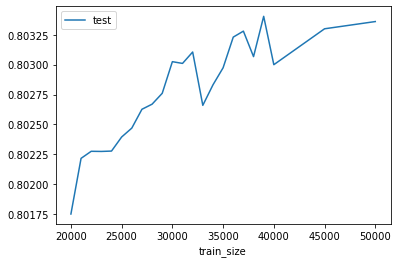

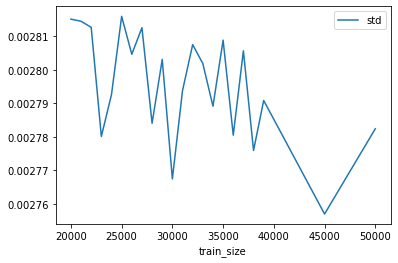

In [13]:
# mean test result and mean test result std versus train sample size
res.groupby('train_size').mean()[['test']].plot()
res.groupby('train_size').mean()[['std']].plot()

In [14]:
n = 5
display(res[res['test'] > 0.808].sort_values(['std']).head(n))
display(res.sort_values(['std']).head(n))
display(res.sort_values(['test'], ascending=False).head(n))

,train,test,std,par_num,seed,train_size,delta
2207,0.810288,0.811072,0.001887,1,629559425,40000,-0.000784
7688,0.814556,0.808565,0.001930,1,425905667,24000,0.005991
7887,0.814732,0.810853,0.002035,0,527255374,30000,0.003879
741,0.814070,0.808281,0.002062,1,592322119,35000,0.005789
2093,0.808806,0.808069,0.002064,0,407474355,34000,0.000737


,train,test,std,par_num,seed,train_size,delta
6525,0.819151,0.800191,0.001769,0,764422455,23000,0.018961
7582,0.812343,0.803279,0.001851,1,271757669,39000,0.009064
6645,0.814278,0.801631,0.001887,0,613536432,29000,0.012647
2207,0.810288,0.811072,0.001887,1,629559425,40000,-0.000784
3921,0.812393,0.807683,0.001914,0,710755558,21000,0.004710


,train,test,std,par_num,seed,train_size,delta
7358,0.809874,0.815326,0.002904,1,106712135,50000,-0.005453
1131,0.810986,0.814730,0.002785,0,952171343,33000,-0.003745
2253,0.810116,0.814569,0.002676,1,704211524,45000,-0.004453
7808,0.810020,0.814520,0.002691,1,262724298,37000,-0.004500
7299,0.810502,0.813876,0.002315,0,819433919,40000,-0.003374


In [15]:
# golden_seeds
temp = res[(res['test'] >= 0.809) & (res['std'] <= 0.0022)]
temp = temp.sort_values(['std'], ascending=False)['seed'].unique()
print(*temp, sep=', ')

407474355, 496946112, 494008192, 610852409, 762885827, 995250534, 840826917, 527255374, 629559425


In [16]:
# prediction for best model
temp = res.sort_values('test', ascending=False).iloc[0]
print(temp.to_frame().T)
models[(temp['seed'], temp['par_num'], temp['train_size'])].to_csv(f'submission_best.csv')

         train      test       std  par_num         seed  train_size     delta
7358  0.809874  0.815326  0.002904      1.0  106712135.0     50000.0 -0.005453


In [17]:
# prediction for model with lowest std of result on test
temp = res[(res['test'] > 0.809)].sort_values('std').iloc[0]
print(temp.to_frame().T)
models[(temp['seed'], temp['par_num'], temp['train_size'])].to_csv(f'submission_less_std.csv')

         train      test       std  par_num         seed  train_size     delta
2207  0.810288  0.811072  0.001887      1.0  629559425.0     40000.0 -0.000784


In [18]:
# handmade voting classifier
def vote_classifier(models, name=''):
    if isinstance(models, dict):
        models = list(models.values())
    vc = pd.concat(models, axis=1)
    t = vc.mean(axis=1)
    t.name = TARGET_FEATURE
    t.to_csv(f'submission_vc{name}.csv')

temp = res[(res['test'] > 0.8085) & (res['std'] < 0.019)].sort_values('std')
vote_classifier([models[(x[1]['seed'], x[1]['par_num'], x[1]['train_size'])] for x in temp.iterrows()])
vote_classifier([models[(x[1]['seed'], x[1]['par_num'], x[1]['train_size'])] for x in temp.iloc[:20].T.iteritems()], '_std_20')

# num of difference in prediction between two voting classifiers
t = pd.concat([pd.read_csv(x, index_col=0) for x in Path().glob('submission_vc*.csv')], axis=1)
sum((t > 0.5).astype(int).diff(axis=1).iloc[:, -1] != 0)

101

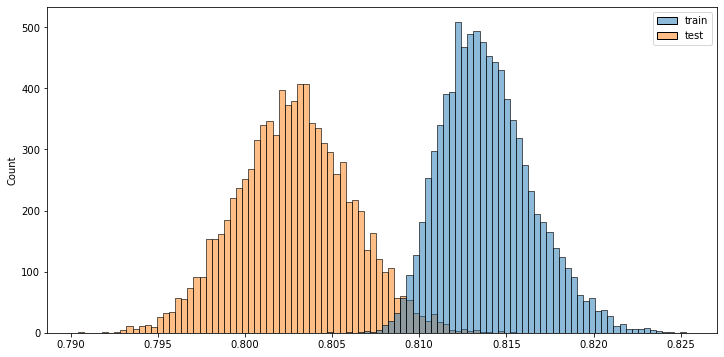

<AxesSubplot:xlabel='test', ylabel='Probability'>

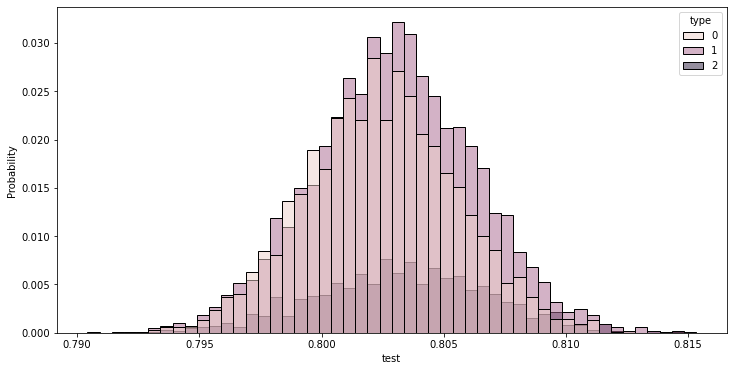

In [19]:
_, ax = plt.subplots(figsize=FIG_SIZES['normal'])
sns.histplot(res[['train', 'test']], bins=100, ax=ax)
plt.show()

_, ax = plt.subplots(figsize=FIG_SIZES['normal'])
temp = res.copy()
temp['type'] = 0
for edge in [30000, 40000]:
    temp['type'] += (temp['train_size'] > edge).astype(int)
sns.histplot(temp[['test', 'type']], x='test', hue='type', stat='probability', bins=50, ax=ax)